In [ ]:
%load_ext autoreload
%autoreload 2

### Imports

In [1]:
import tensorflow as tf
from psychrnn.backend.models.basic import Basic
from psychrnn.backend.gain.gain2 import Basic2
from psychrnn.backend.gain.loss import rt_mask_mse_06, rt_mask_mse_07, rt_mask_mse_08
from psychrnn.tasks.checker import Checkerboard2AFC

from tqdm import tqdm
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
%matplotlib inline

import os

### Initialize Task

In [2]:
experiment = 'interactive'
name = 'basic'

In [3]:
dt = 10
tau = 50
T = 5000
N_batch = 50
N_rec = 100

In [4]:
task = Checkerboard2AFC(dt=dt, tau=tau, T=T, N_batch=N_batch, noise = 0.25)

### Set up parameters

In [5]:
network_params = task.get_task_params()
network_params['name'] = name
network_params['N_rec'] = N_rec
network_params['rec_noise'] = 0.1

network_params["transfer_function"] = tf.nn.relu
network_params["output_transfer_function"] = tf.nn.sigmoid

network_params["loss_function"] = "rt_mask_mse"
network_params["rt_mask_mse"] = rt_mask_mse_07
# choose bound of random gain
network_params['gain_bound'] = [1, 1]

In [6]:
try:
    model.destruct()
except:
    pass

model = Basic2(network_params)

### Train Model

In [7]:
trials = 25000

train_params = {}

###################################################
## set the name of the save path
###################################################
# saveWeightPath = "./weights/gain2_" + str(network_params['gain_bound'][0]) + str(network_params['gain_bound'][1]) + 'recN' + str(network_params['rec_noise'])
saveWeightPath = "./weights/compareGain3RecNoise0.1"
train_params['save_weights_path'] =  saveWeightPath
train_params['training_iters'] = trials
train_params['learning_rate'] = .001
train_params['loss_epoch'] = 10
train_params['save_training_weights_epoch'] = 1000 / N_batch


In [8]:
losses, initialTime, trainTime = model.train(task, train_params)

#####################################################
## save losses
#####################################################

# loss_name = "./losses/gain2_" + str(network_params['gain_bound'][0]) + str(network_params['gain_bound'][1]) + 'recN' + str(network_params['rec_noise']) + ".txt"
loss_name = "./weights/compareGain3RecNoise0.1.txt"


print("Save losses to " + loss_name)
with open(loss_name, 'w') as f:
    for item in losses:
        f.write("%s\n" % item)


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Iter 500, Minibatch Loss= 0.116357
Iter 1000, Minibatch Loss= 0.078660
Iter 1500, Minibatch Loss= 0.060112
Iter 2000, Minibatch Loss= 0.049657
Iter 2500, Minibatch Loss= 0.042811
Iter 3000, Minibatch Loss= 0.034713
Iter 3500, Minibatch Loss= 0.030848
Iter 4000, Minibatch Loss= 0.046680
Iter 4500, Minibatch Loss= 0.055831
Iter 5000, Minibatch Loss= 0.030462
Iter 5500, Minibatch Loss= 0.023179
Iter 6000, Minibatch Loss= 0.044683
Iter 6500, Minibatch Loss= 0.022943
Iter 7000, Minibatch Loss= 0.030614
Iter 7500, Minibatch Loss= 0.023364
Iter 8000, Minibatch Loss= 0.022908
Iter 8500, Minibatch Loss= 0.024233
Iter 9000, Minibatch Loss= 0.019541
Iter 9500, Minibatch Loss= 0.022294
Iter 10000, Minibatch Loss= 0.022391
Iter 10500, Minibatch Loss= 0.012668
Iter 11000, Minibatch Loss= 0.014353
Iter 11500, Minibatch Loss= 0.025710
Iter 12000, Minibatch Loss= 0.024352
Iter 12500, Minibatch Loss= 0.016050
I

Text(0.5, 1.0, 'Loss During Training')

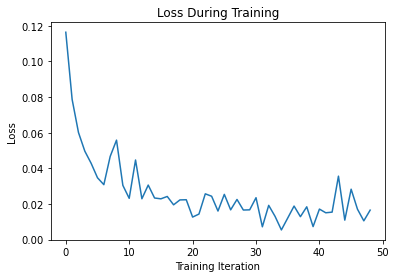

In [9]:
plt.plot(losses)
plt.ylabel("Loss")
plt.xlabel("Training Iteration")
plt.title("Loss During Training")

### Test on 5000 trials to examine performance

In [10]:
trials = 5000
batches = int(np.ceil(trials / N_batch))

rnn_state = np.zeros((trials, task.N_steps, model.N_rec))
rnn_out = np.zeros((trials, task.N_steps, model.N_out))

coherence = np.zeros(trials)
green_side = np.zeros(trials)
target_onset = np.zeros(trials)
checker_onset = np.zeros(trials)

decision = np.zeros(trials)
rt = np.zeros(trials)

In [11]:
for b in tqdm(range(batches)):
    x, y, m, params = task.get_trial_batch()
    outputs, states, inputs = model.test(x)
    
    start_index = N_batch * b
    end_index = N_batch * (b + 1)
    rnn_state[start_index:end_index] = states
    rnn_out[start_index:end_index] = outputs
    
    thr = np.where(outputs > 0.7)
    
    for i in range(N_batch):
        index = start_index + i
        
        coherence[index] = params[i]["coherence"]
        green_side[index] = params[i]["side"]
        target_onset[index] = params[i]["target_onset"]
        checker_onset[index] = params[i]["checker_onset"]
        
        thr_time = thr[1][thr[0]==i][0] if sum(thr[0]==i) > 0 else outputs.shape[1]
        thr_unit = thr[2][thr[0]==i][0] if sum(thr[0]==i) > 0 else np.argmax(outputs[i, -1])
        decision[index] = thr_unit
        rt[index] = thr_time*task.dt - target_onset[index] - checker_onset[index]       

100%|██████████| 100/100 [00:53<00:00,  1.87it/s]


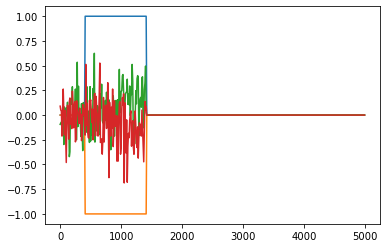

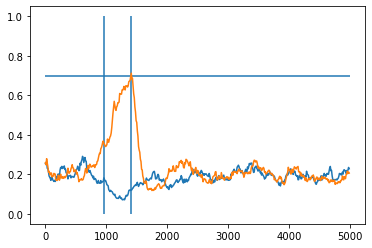

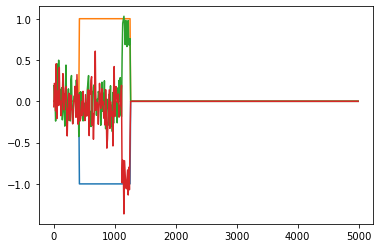

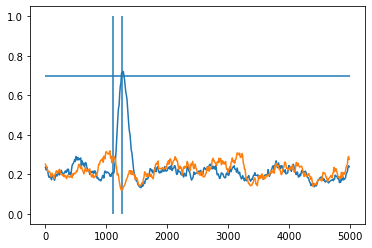

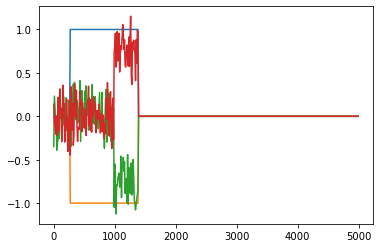

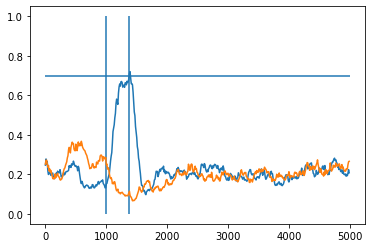

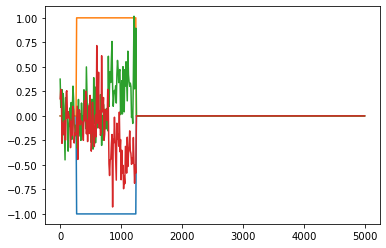

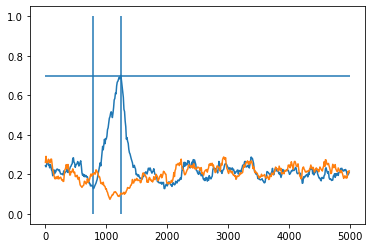

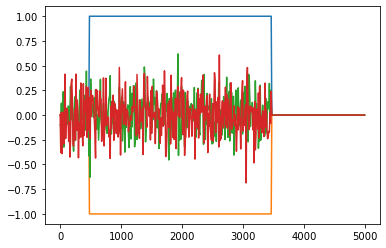

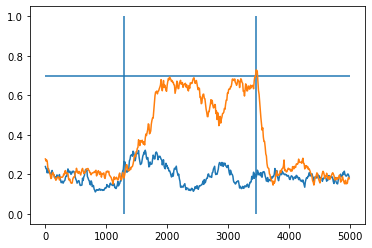

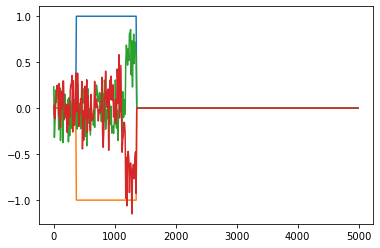

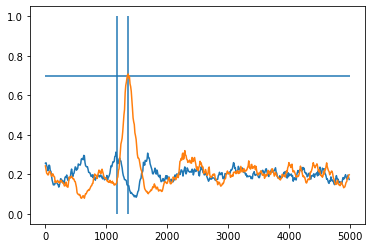

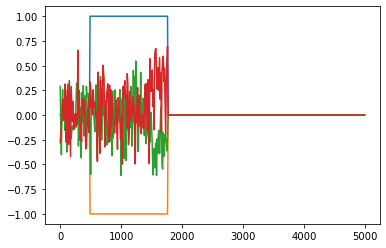

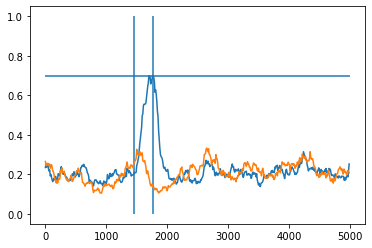

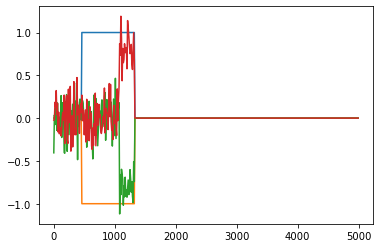

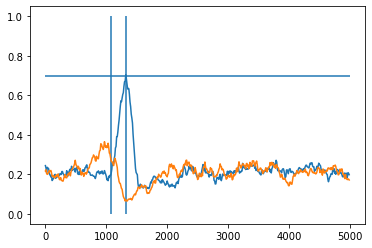

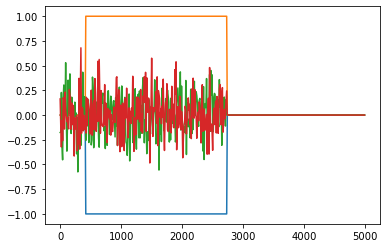

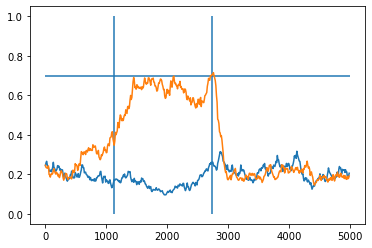

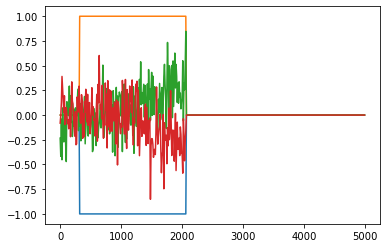

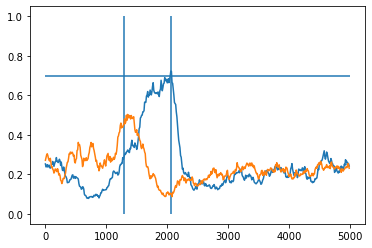

In [12]:
#onsets = [p["onset_time"] for p in params]
onsets = target_onset[-N_batch:] + checker_onset[-N_batch:]
rts = rt[-N_batch:]
for i in range(10):
    plt.figure()
    plt.plot(np.arange(0, 5000, 10), inputs[i, :, 0])
    plt.plot(np.arange(0, 5000, 10), inputs[i, :, 1])
    plt.plot(np.arange(0, 5000, 10), inputs[i, :, 2])
    plt.plot(np.arange(0, 5000, 10), inputs[i, :, 3])

    plt.figure()
    plt.plot(np.arange(0, 5000, 10), outputs[i, :, 0])
    plt.plot(np.arange(0, 5000, 10), outputs[i, :, 1])
    
    plt.vlines(onsets[i], 0, 1)
    plt.vlines(onsets[i] + rts[i], 0, 1)
    plt.hlines(0.7, 0, 5000)

In [13]:
correct_side = np.array([gs if coh > 0 else abs(gs-1) for coh, gs in zip(coherence, green_side)])
green_decision = np.array([int(dec == gs) for dec, gs in zip(decision, green_side)])
checker_df = pd.DataFrame({'trial' : np.arange(trials),
                           'coherence' : coherence,
                           'coherence_bin' : np.round(coherence, 1),
                           'green_side' : green_side,
                           'correct_side' : correct_side,
                           'target_onset' : target_onset,
                           'checker_onset' : checker_onset,
                           'decision' : decision,
                           'green_decision' : green_decision,
                           'decision_time' : rt,
                           'correct_decision' : (decision == correct_side).astype(int)})
checker_mean = checker_df.groupby('coherence_bin').mean().reset_index()

#######################
## summary result save path

# resultPath = "./resultData/summary_gain2_" + str(network_params['gain_bound'][0]) + str(network_params['gain_bound'][1]) + 'recN' + str(network_params['rec_noise']) + ".csv"
# checker_df.to_csv(resultPath)

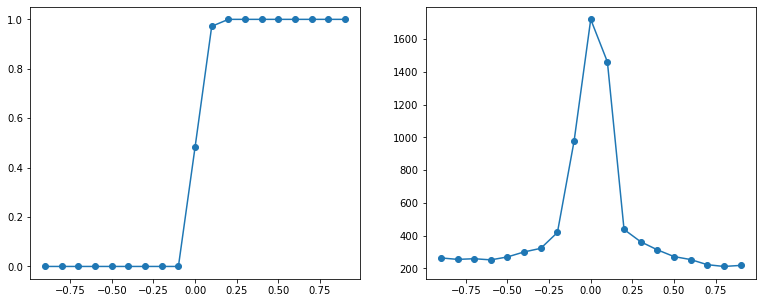

In [14]:
plt.figure(figsize=(13, 5))
plt.subplot(1,2,1)
plt.plot(checker_mean['coherence_bin'], checker_mean['green_decision'])
plt.scatter(checker_mean['coherence_bin'], checker_mean['green_decision'])

plt.subplot(1,2,2)
plt.plot(checker_mean['coherence_bin'], checker_mean['decision_time'])
plt.scatter(checker_mean['coherence_bin'], checker_mean['decision_time'])



# RT within coherence

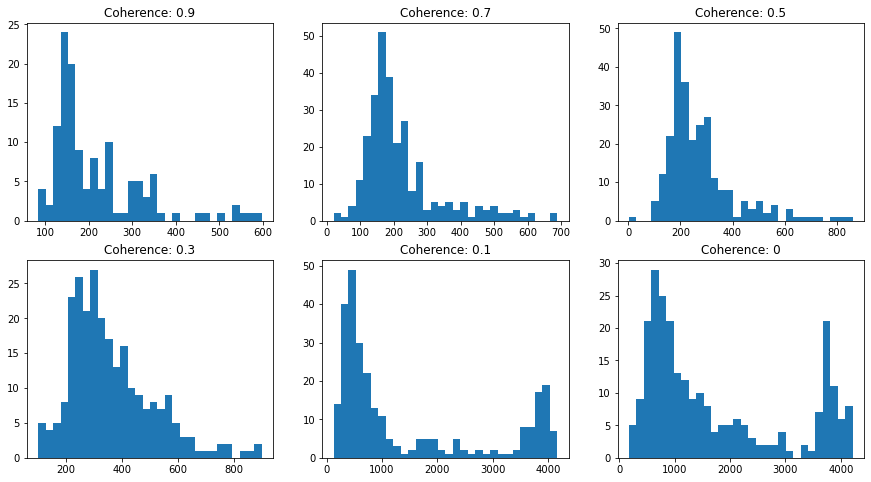

In [15]:
idx = 1
plt.figure(figsize=(15, 8))
for i in [0.9,0.7,0.5,0.3,0.1,0]:
    a = checker_df['coherence_bin'] == i
    groupCo = checker_df.loc[a,:]
    RT = groupCo["decision_time"]
    plt.subplot(2,3,idx)
    plt.hist(RT, bins = 30)
    plt.title("Coherence: " + str(i))
    idx = idx + 1


In [ ]:
# s = tf.zeros((1,100), dtype=tf.bool)
# testR = tf.random.uniform(tf.shape(input=s), minval=1, maxval=2, dtype=tf.dtypes.float32)
# sess = tf.Session()
# a = sess.run(testR)
# sess.close()
# a

In [18]:
model.destruct()

# Use one pre-trained model to run

In [19]:
dt = 10
tau = 50
T = 5000
N_batch = 50
N_rec = 100
experiment = 'interactive'
name = 'basic'

task = Checkerboard2AFC(dt=dt, tau=tau, T=T, N_batch=N_batch)

network_params = task.get_task_params()
network_params['name'] = name
network_params['N_rec'] = N_rec
network_params['rec_noise'] = 0.1
network_params["transfer_function"] = tf.nn.relu
network_params["output_transfer_function"] = tf.nn.sigmoid
network_params["loss_function"] = "rt_mask_mse"
network_params["rt_mask_mse"] = rt_mask_mse_07
network_params['load_weights_path'] = saveWeightPath + ".npz"
network_params['gain_bound'] = [1, 1]
model2 = Basic2(network_params)

In [20]:
trials = 5000
batches = int(np.ceil(trials / N_batch))

rnn_state = np.zeros((trials, task.N_steps, model2.N_rec))
rnn_out = np.zeros((trials, task.N_steps, model2.N_out))

coherence = np.zeros(trials)
green_side = np.zeros(trials)
target_onset = np.zeros(trials)
checker_onset = np.zeros(trials)
decision = np.zeros(trials)
rt = np.zeros(trials)

for b in tqdm(range(batches)):
    x, y, m, params = task.get_trial_batch()
    outputs, states, inputs = model2.test(x)
    
    start_index = N_batch * b
    end_index = N_batch * (b + 1)
    rnn_state[start_index:end_index] = states
    rnn_out[start_index:end_index] = outputs
    
    thr = np.where(outputs > 0.7)
    
    for i in range(N_batch):
        index = start_index + i
        
        coherence[index] = params[i]["coherence"]
        green_side[index] = params[i]["side"]
        target_onset[index] = params[i]["target_onset"]
        checker_onset[index] = params[i]["checker_onset"]
        
        thr_time = thr[1][thr[0]==i][0] if sum(thr[0]==i) > 0 else outputs.shape[1]
        thr_unit = thr[2][thr[0]==i][0] if sum(thr[0]==i) > 0 else np.argmax(outputs[i, -1])
        decision[index] = thr_unit
        rt[index] = thr_time*task.dt - target_onset[index] - checker_onset[index]       

100%|██████████| 100/100 [01:02<00:00,  1.60it/s]


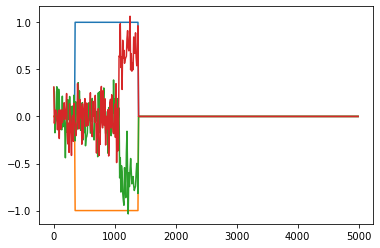

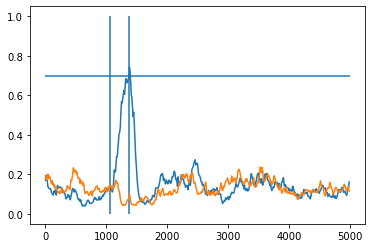

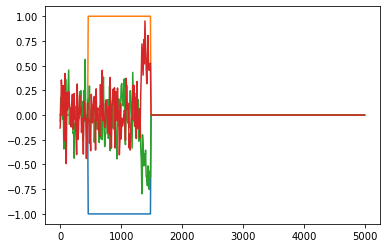

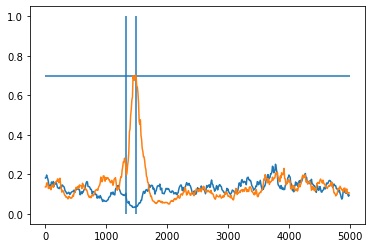

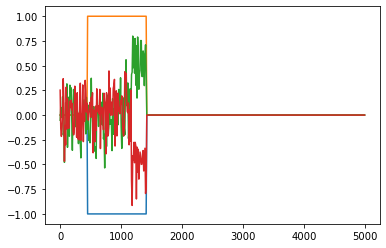

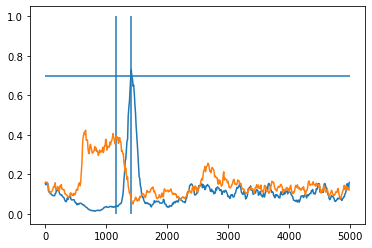

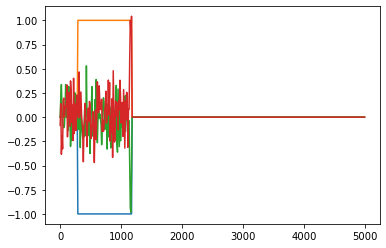

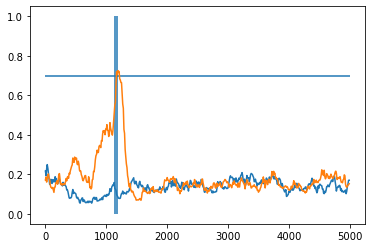

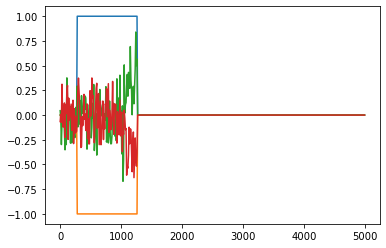

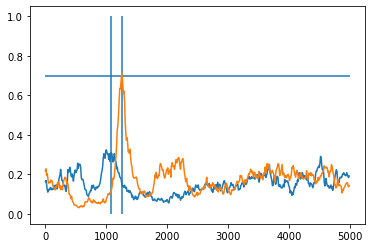

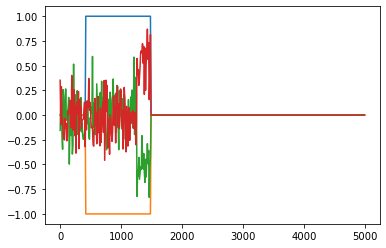

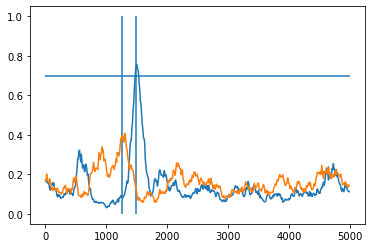

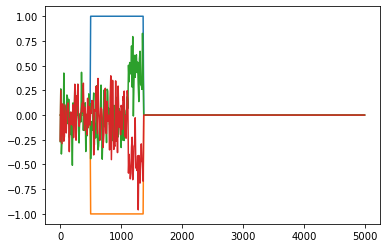

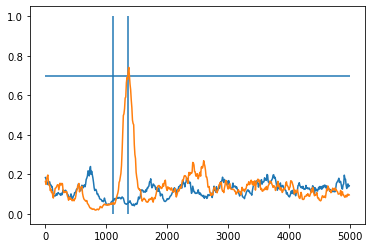

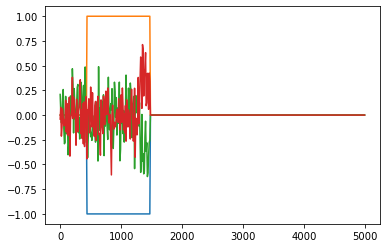

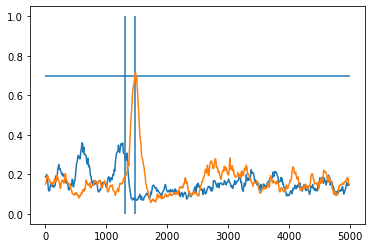

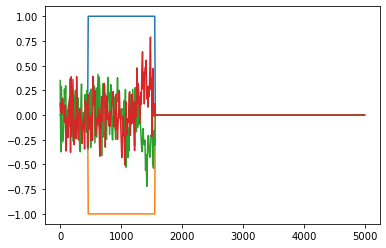

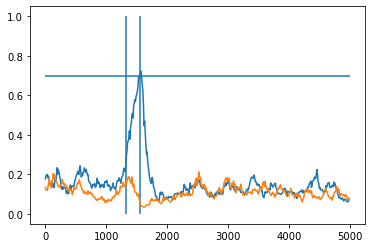

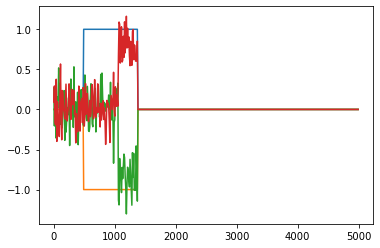

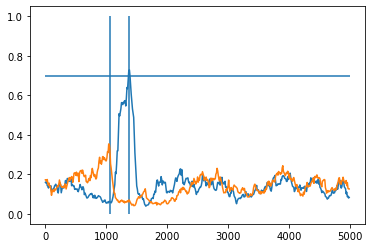

In [22]:
#onsets = [p["onset_time"] for p in params]
onsets = target_onset[-N_batch:] + checker_onset[-N_batch:]
rts = rt[-N_batch:]
for i in range(10):
    plt.figure()
    plt.plot(np.arange(0, T, 10), inputs[i, :, 0])
    plt.plot(np.arange(0, T, 10), inputs[i, :, 1])
    plt.plot(np.arange(0, T, 10), inputs[i, :, 2])
    plt.plot(np.arange(0, T, 10), inputs[i, :, 3])

    plt.figure()
    plt.plot(np.arange(0, T, 10), outputs[i, :, 0])
    plt.plot(np.arange(0, T, 10), outputs[i, :, 1])
    
    plt.vlines(onsets[i], 0, 1)
    plt.vlines(onsets[i] + rts[i], 0, 1)
    plt.hlines(0.7, 0, T)

In [23]:
correct_side = np.array([gs if coh > 0 else abs(gs-1) for coh, gs in zip(coherence, green_side)])
green_decision = np.array([int(dec == gs) for dec, gs in zip(decision, green_side)])
checker_df = pd.DataFrame({'trial' : np.arange(trials),
                           'coherence' : coherence,
                           'coherence_bin' : np.round(coherence, 1),
                           'green_side' : green_side,
                           'correct_side' : correct_side,
                           'target_onset' : target_onset,
                           'checker_onset' : checker_onset,
                           'decision' : decision,
                           'green_decision' : green_decision,
                           'decision_time' : rt,
                           'correct_decision' : (decision == correct_side).astype(int)})
checker_mean = checker_df.groupby('coherence_bin').mean().reset_index()

#######################
## summary result saving path

# resultPath = "./resultData/summary_recNoise" + str(network_params['rec_noise']) + "round" + str(round) + ".csv"
# checker_df.to_csv(resultPath)

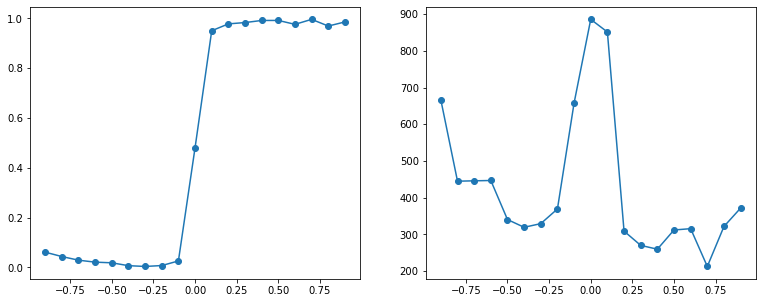

In [24]:
plt.figure(figsize=(13, 5))
plt.subplot(1,2,1)
plt.plot(checker_mean['coherence_bin'], checker_mean['green_decision'])
plt.scatter(checker_mean['coherence_bin'], checker_mean['green_decision'])

plt.subplot(1,2,2)
plt.plot(checker_mean['coherence_bin'], checker_mean['decision_time'])
plt.scatter(checker_mean['coherence_bin'], checker_mean['decision_time'])



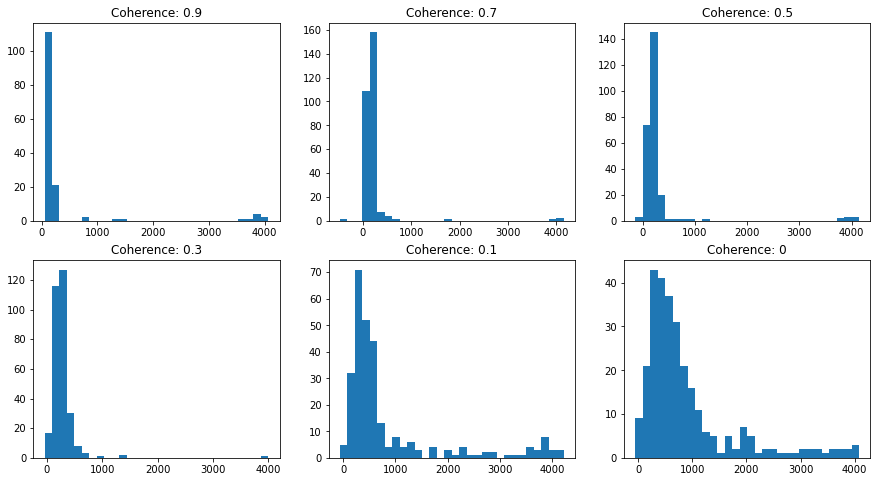

In [26]:
idx = 1
plt.figure(figsize=(15, 8))
for i in [0.9,0.7,0.5,0.3,0.1,0]:
    a = checker_df['coherence_bin'] == i
    groupCo = checker_df.loc[a,:]
    RT = groupCo["decision_time"]
    plt.subplot(2,3,idx)
    plt.hist(RT, bins = 30)
    plt.title("Coherence: " + str(i))
    idx = idx + 1

# plt.savefig("gain1.png")

In [12]:
model2.destruct()

NameError: name 'model2' is not defined